In [32]:
# All of the common imports and settings
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, feature, filters, segmentation, measure, draw, exposure, morphology, transform
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2 # OpenCV
%matplotlib inline


from video import run_video

import imutils

In [33]:
image = color.rgb2gray(io.imread("Print_Payment_Receipt.JPG"))

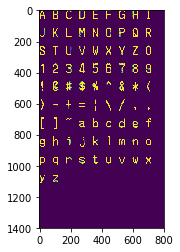

In [34]:
digits = color.rgb2gray(io.imread("Merchant_digits_2.png"))
plt.imshow(digits)

In [35]:
    SAMPLES = [0]

    height = 65
    h_gap = 50
    width = 45
    w_gap = 40

    training_data = []

    for i in range(10):
        for j in range(9):
            top = i * (height  + h_gap)
            left = j * (width + w_gap)
            bottom = top + height
            right = left + width

            digit_im = digits[top:bottom, left:right]


            fv = feature.hog(digit_im*255, block_norm = 'L2-Hys').astype('float32')


            training_data.append(fv)

    training_data = np.vstack(training_data)[:-7]

    resps = []
    characters = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O"
                   ,"P","Q","R","S","T","U","V","W","X","Y","Z","0","1","2","3"
                  ,"4","5","6","7","8","9","!","@","#","$","%","^","&","*","("
                  ,")","-","+","=","|","\\","/",",",".","[","]","~","a","b","c"
                  ,"d","e","f","g","h","i","j","k","l","m","n","o","p","q","r"
                  ,"s","t","u","v","w","x","y","z"]

    for ch in characters:
        resps.append(ord(ch))
    resps = np.array(resps)

svm = cv2.ml.SVM_create()

svm.setKernel(cv2.ml.SVM_LINEAR)

svm.setType(cv2.ml.SVM_C_SVC)

svm.train(training_data, cv2.ml.ROW_SAMPLE, resps)


True

In [40]:
def getLetters(im):

    # Basic pre-processing
    image11 = im
    gray = color.rgb2gray(im) # or cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    blur = (filters.gaussian(gray, 1.5)*255).round().astype('uint8') # or cv2.GaussianBlur(gray, (-1, -1), 1.5, 1.5) or cv2.GaussianBlur(gray, (11, 11), 0)
    th = blur <= filters.threshold_local(blur, 7, 'mean', 2) # or th = cv2.bitwise_not(cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2))

    th = morphology.remove_small_objects(th, 200)
    # Connected components to get largest component
    lbls = measure.label(th, connectivity=2)
    props = measure.regionprops(lbls)


    counter = 0
    receipt_letters = []
    receipt_text = np.zeros(im.shape, 'uint8')
    


    for k in props:

        h,w = k.image.shape[:2]

        if counter == 10:
            break

        if w <40:    
            # Deskew/Rotate image
            if False: #abs(k.moments_central[0,2]) > 1e-2:
                skew = k.moments_central[1,1]/k.moments_central[0,2]
                M = np.array([[1, -skew, height*skew], [0, 1, 0]], 'float32')
                im = cv2.warpAffine(k.image.view('uint8'), M, (width, height), flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)
            else:
                im = cv2.resize(k.image.view('uint8'),(width,height) ).view(bool)

            receipt_letters.append(im)
            
            _,y,x,_ = k.bbox
            
            
            fv = feature.hog(receipt_letters[counter]*255, block_norm='L2-Hys').astype('float32')
            # Ask SVM to predict
            digit = svm.predict(fv[None,:])[1].squeeze()
            
            text =chr(digit)
            cv2.putText(image11, text, (y,x), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0))
            counter +=1
            
    return image11
    

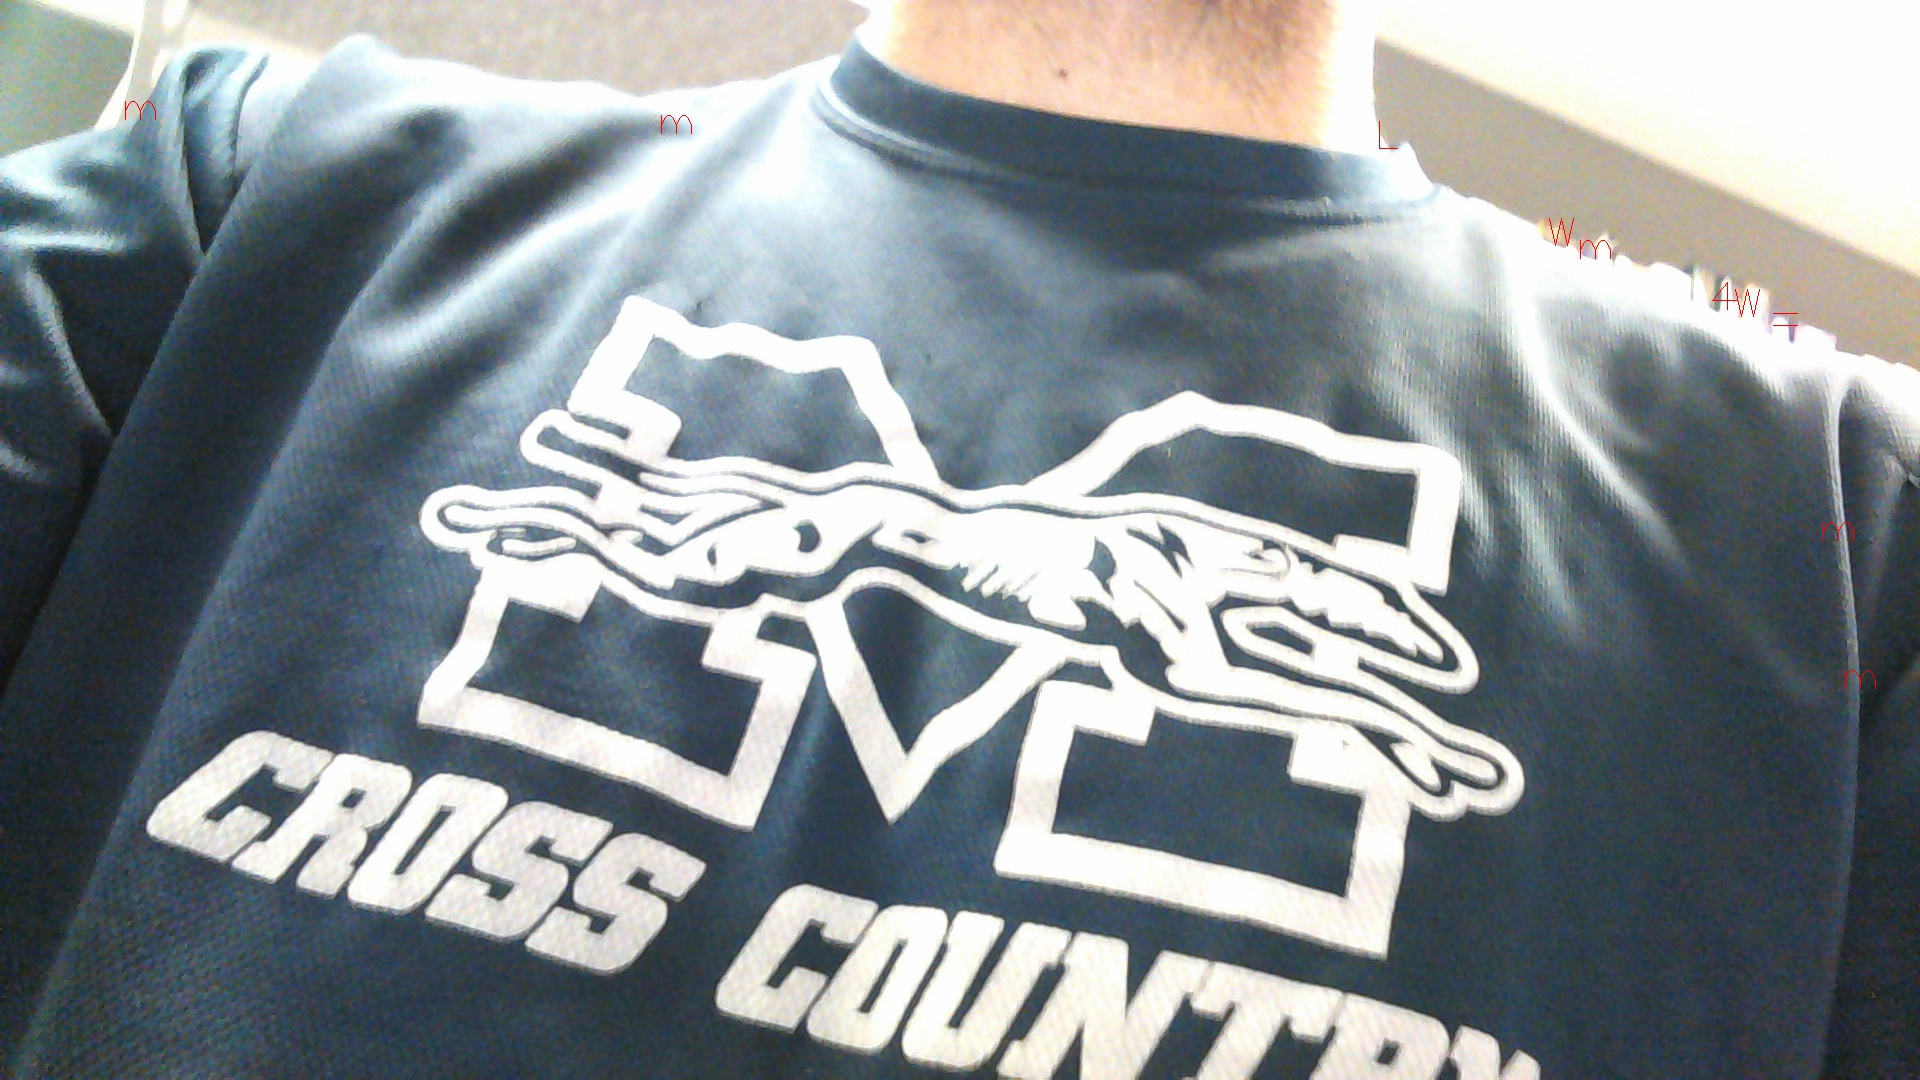

array([[[151, 146, 163],
        [149, 144, 162],
        [147, 148, 141],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[142, 149, 158],
        [142, 149, 158],
        [140, 153, 142],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[134, 152, 153],
        [135, 153, 154],
        [135, 156, 140],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[ 58,  48,  81],
        [ 58,  48,  81],
        [ 46,  50,  83],
        ...,
        [ 42,  38,  53],
        [ 56,  47,  59],
        [ 73,  65,  77]],

       [[ 70,  47,  75],
        [ 69,  46,  74],
        [ 55,  51,  75],
        ...,
        [ 41,  39,  51],
        [ 45,  45,  49],
        [ 52,  52,  56]],

       [[ 78,  45,  65],
        [ 78,  45,  65],
        [ 61,  51,  68],
        ...,
        [ 41,  44,  54],
        [ 37,  46,  45],
        [ 38,  47,  46]]

In [41]:
run_video(getLetters, camera_num=0)